In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Changing directory to Session 10 project folder
% cd /content/gdrive/My Drive/TSAI-EVA-7.0/13_ViT/

/content/gdrive/My Drive/TSAI-EVA-7.0/13_ViT


In [3]:
!pip install vit-pytorch linformer

     |████████████████████████████████| 50 kB 3.1 MB/s 


# Imports

In [4]:
# loading Libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

In [5]:
# import Linformer

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [6]:
# import torch and related libraries 

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

In [7]:
# to unzip the datasets

import zipfile 

In [8]:
#sklearn to split the data

from sklearn.model_selection import train_test_split

# Hyper-parameters

In [17]:
# definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 10
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

# Data 

In [10]:
! ls 

data  dogs-vs-cats-redux-kernels-edition.zip  Session_13_ViT.ipynb


In [11]:
# with zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition.zip') as dog_cat_zip:
#     dog_cat_zip.extractall('data')

In [12]:
# Load data

os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

In [13]:
# # Unzipping dataset
# with zipfile.ZipFile('data/train.zip') as train_zip:
#     train_zip.extractall('data')

In [14]:
# with zipfile.ZipFile('data/test.zip') as test_zip:
#     test_zip.extractall('data')

In [18]:
# Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [19]:
# Printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 6180


In [20]:
# Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

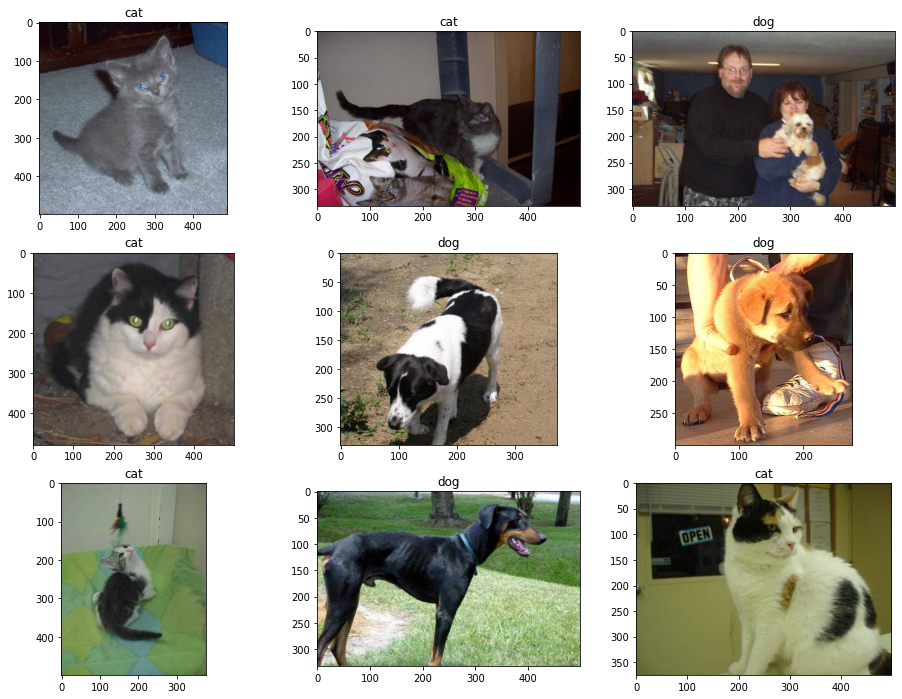

In [21]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[random_idx[idx]])
    ax.set_title(labels[random_idx[idx]])
    ax.imshow(img)

## Train/Validation Split

In [22]:
# Splitting train and validation list
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=42)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 6180


## Transforms

In [23]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [24]:
# Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label


In [25]:
# defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [26]:
# loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

# Transformers

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [29]:
# Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)


In [30]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [32]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 49, 3072]               0
            Linear-2              [-1, 49, 128]         393,344
         LayerNorm-3              [-1, 50, 128]             256
            Linear-4              [-1, 50, 128]          16,384
            Linear-5              [-1, 50, 128]          16,384
            Linear-6              [-1, 50, 128]          16,384
           Dropout-7            [-1, 8, 50, 64]               0
            Linear-8              [-1, 50, 128]          16,512
LinformerSelfAttention-9              [-1, 50, 128]               0
          PreNorm-10              [-1, 50, 128]               0
        LayerNorm-11              [-1, 50, 128]             256
           Linear-12              [-1, 50, 512]          66,048
             GELU-13              [-1, 50, 512]               0
          Dropout-14              [

# Training

In [31]:
# start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6958 - acc: 0.5059 - val_loss : 0.6957 - val_acc: 0.5014



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6910 - acc: 0.5247 - val_loss : 0.6860 - val_acc: 0.5487



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6864 - acc: 0.5429 - val_loss : 0.6804 - val_acc: 0.5609



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6793 - acc: 0.5704 - val_loss : 0.6746 - val_acc: 0.5815



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6705 - acc: 0.5849 - val_loss : 0.6633 - val_acc: 0.5882



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6597 - acc: 0.5986 - val_loss : 0.6523 - val_acc: 0.6023



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6547 - acc: 0.6041 - val_loss : 0.6436 - val_acc: 0.6165



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6470 - acc: 0.6145 - val_loss : 0.6424 - val_acc: 0.6171



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6421 - acc: 0.6179 - val_loss : 0.6394 - val_acc: 0.6226



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6348 - acc: 0.6276 - val_loss : 0.6229 - val_acc: 0.6487

